In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import numpy as np
cwd = os.getcwd()
alpha = 0.05

### Before running this script, put the TCGA datasets into a directory datasets/ and place the datasets-directory in the same directory as this script  
### Important: please use the download script provided in our repository to download TCGA data, or make sure to transpose the gene expression data, i.e. samples x genes as index x columns  
##### besides $\Chi^{2}$ tests of the stage variable and each of the confunders age, ethnicity, and sex, the block sizes of the partitions induced by each of the variables are printed by this script. For the age-induced partition, that is defined by the lower and upper quartile of samples according to their age at initial diagnosis, the quartile range is printed in the form:  
##### lower: \[min value, lower quartile\]  
##### upper: (upper quartile, max value\]

In [2]:
def align(pheno, expr):
    keep = pheno.index.isin(expr.index)
    pheno = pheno[keep]
    pheno = pheno[pheno.index.isin(expr.index)]
    samples = pheno.index            
    expr = expr.loc[samples]
    expr = expr.loc[:, (expr.std() != 0)]
    pheno = pheno[pheno.index.isin(expr.index)]
    return pheno, expr

In [3]:
def get_conf_partition(pheno_data_orig, confounder_selector, rank, thresh=0):
    pheno_data = pheno_data_orig.copy()
    indices = None
    blocks = []
    printer = []
    pheno_field = ''  
    if confounder_selector == 'sex':
        pheno_field = 'gender.demographic'
    elif confounder_selector == 'ethnicity':
        pheno_field = 'race.demographic'
    elif confounder_selector == 'age':
        pheno_field = 'age_at_initial_pathologic_diagnosis'
    elif confounder_selector == 'stage':
        pheno_field = 'tumor_stage.diagnoses'
        pheno_data = pheno_data[pheno_data[pheno_field] != 'stage x']
        pheno_data.loc[pheno_data['tumor_stage.diagnoses'].str.strip().isin(['stage ia', 'stage ib', 'stage ic']), pheno_field] = 'stage i'
        pheno_data.loc[pheno_data['tumor_stage.diagnoses'].str.strip().isin(['stage iia', 'stage iib', 'stage iic']), pheno_field] = 'stage ii'
        pheno_data.loc[pheno_data['tumor_stage.diagnoses'].str.strip().isin(['stage iiia', 'stage iiib', 'stage iiic', 'stage iv', 'stage iva', 'stage ivb', 'stage ivc']), pheno_field] = 'stage iii'
    elif confounder_selector == 'type':
        pheno_field = 'cohort'
    pheno_data = pheno_data[pheno_data[pheno_field] != 'not reported']
    pheno_data = pheno_data[pheno_data[pheno_field].notna()]
    if confounder_selector != 'age':
        blocks = sorted(list(set(pheno_data[pheno_field].str.strip().values)))
        for block_attr in blocks:
            samples = pheno_data.loc[pheno_data[pheno_field].str.strip() == block_attr].index.tolist()
            if len(samples) >= thresh:
                printer.append((samples, block_attr))
    elif confounder_selector == 'age':
        samples_lower = []
        samples_upper = []
        for cohort in set(pheno_data['cohort'].str.strip().values):
            pheno_cohort = pheno_data[pheno_data['cohort'] == cohort]
            lower, upper = pheno_cohort[pheno_field].quantile(0.25), pheno_cohort[pheno_field].quantile(0.75)
            print(f'\tlower: [{pheno_cohort[pheno_field].values.min()},{lower}]')
            print(f'\tupper: ({upper},{pheno_cohort[pheno_field].values.max()}]')
            samples_lower.extend(pheno_cohort.loc[pheno_cohort[pheno_field] <= lower].index.tolist())
            samples_upper.extend(pheno_cohort.loc[pheno_cohort[pheno_field] > upper].index.tolist())
        if len(samples_lower) >= thresh and len(samples_upper) >= thresh:
            printer.append((samples_lower, 'lower'))
            printer.append((samples_upper, 'upper'))
    return printer

In [4]:
def stage_conf_chi(pheno):
    confs = ['age', 'ethnicity', 'sex', 'stage']
    sc = {'age':np.nan, 'ethnicity':np.nan, 'sex':np.nan}
    for conf in confs:
        out = []
        confusion_table = pd.DataFrame()
        print(conf)
        orig_conf_partition = get_conf_partition(pheno, conf, 0, thresh=20)
        [print(str(bl[1]) + ': ' + str(len(bl[0]))) for bl in orig_conf_partition]
        for bl in orig_conf_partition:
            block = bl[0]
            stage_partition = get_conf_partition(pheno[pheno.index.isin(block)], 'stage', 0)
            for stage_block in stage_partition:
                confusion_table.loc[stage_block[1], bl[1]] = len(stage_block[0])
        try:
            if len(confusion_table) <= 1:
                continue
            confusion_table = confusion_table.dropna()
            chi2, p, dof, ex = chi2_contingency(confusion_table, correction=False)
            sc[str(conf)] = p
        except:
            continue
    return sc

In [5]:
def get_expression_data(cohort):
    expression_data = pd.read_csv(os.path.join(os.getcwd(), 'datasets', f'TCGA-{cohort}.htseq_fpkm.tsv'), sep='\t', header=0, index_col=0)
    expression_data.columns = expression_data.columns.str.split('.').str[0].tolist()
    # gene filtering is removed here, because it does not affect the set of samples present in the file
    return expression_data


In [6]:
def get_pheno_data(cohort):
    tissue_type_field, tissue_type = 'sample_type.samples', 'Primary Tumor'
    pheno_data = pd.read_csv(os.path.join(os.getcwd(), 'datasets', f'TCGA-{cohort}.GDC_phenotype.tsv'), sep='\t', header=0, index_col='submitter_id.samples')
    assert len(pheno_data.iloc[0]) == len(pheno_data.iloc[0].values)
    pheno_data['cohort'] = str(cohort)
    pheno_data =  pheno_data[pheno_data[tissue_type_field] == tissue_type]
    return pheno_data

In [7]:
df = pd.DataFrame(columns=['cohort', 'age', 'ethnicity', 'sex'])
cohorts = ['BRCA', 'COAD', 'HNSC', 'KIRC', 'KIRP', 'LUSC', 'PCPG', 'READ', 'STAD']
for cohort in cohorts:
    print(cohort)
    # read single data
    expr = get_expression_data(cohort)
    pheno = get_pheno_data(cohort)
    # align pheno and expr
    pheno, expr = align(pheno, expr)
    sc = stage_conf_chi(pheno)
    temp = pd.DataFrame({'cohort':[str(cohort)], 'age':[sc['age']], 'ethnicity':[sc['ethnicity']], 'sex':[sc['sex']]})
    df = pd.concat([df, temp])  
    print('\n')

BRCA
age
	lower: [26.0,49.0]
	upper: (67.0,90.0]
lower: 297
upper: 273
ethnicity
asian: 61
black or african american: 183
white: 757
sex
female: 1084
stage
stage i: 182
stage ii: 623
stage iii: 268


COAD
age
	lower: [31.0,58.0]
	upper: (77.0,90.0]
lower: 118
upper: 115
ethnicity
black or african american: 61
white: 223
sex
female: 221
male: 246
stage
stage i: 78
stage ii: 182
stage iii: 196


HNSC
age
	lower: [19.0,53.0]
	upper: (69.0,90.0]
lower: 130
upper: 110
ethnicity
black or african american: 47
white: 426
sex
female: 133
male: 367
stage
stage i: 25
stage ii: 70
stage iii: 337


KIRC
age
	lower: [26,52.0]
	upper: (70.0,90]
lower: 145
upper: 127
ethnicity
black or african american: 56
white: 463
sex
female: 186
male: 348
stage
stage i: 268
stage ii: 58
stage iii: 205


KIRP
age
	lower: [28.0,54.0]
	upper: (71.0,88.0]
lower: 80
upper: 62
ethnicity
black or african american: 60
white: 205
sex
female: 76
male: 212
stage
stage i: 172
stage ii: 21
stage iii: 66


LUSC
age
	lower: [39.

In [8]:
df_work = df.copy()
df_work = df_work.dropna().reset_index()
df_work = df_work.reset_index()
df_work.index = df_work['cohort'].values
df_work = df_work.drop(['cohort', 'index', 'level_0'], axis=1)
df_work.columns = ['age', 'ethnicity', 'sex']


In [9]:
def convert_pvalue_to_asterisks(pvalue):
    if float(pvalue) < 0.0001:
        return "* * * *"
    elif float(pvalue) < 0.001:
        return "* * *"
    elif float(pvalue) < 0.01:
        return "* *"
    elif float(pvalue) < 0.05:
        return "*"
    return 'ns'

In [10]:
df_work

,age,ethnicity,sex
BRCA,0.214586,0.099118,1.000000
COAD,0.004565,0.547878,0.862812
HNSC,0.187719,0.053525,0.013494
KIRC,0.098093,0.005095,0.062446
KIRP,0.753327,0.215263,0.811879
LUSC,0.010682,0.110097,0.549968
READ,0.899982,1.000000,0.795696
STAD,0.108285,0.023936,0.594784


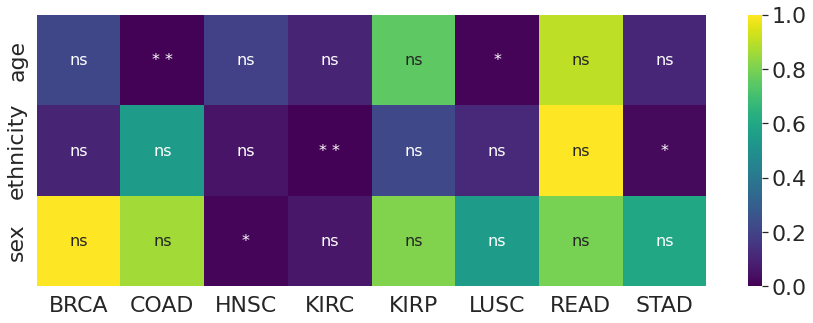

In [11]:
# when getting the (nested) partitions, the 20-sample-threshold is applied for the confounders but removed for the 
# stage variable.
sns.set(font_scale=2)
cmap2 = plt.colormaps['viridis']
cmap1 = plt.colormaps["seismic"]
fig, ax = plt.subplots(figsize=(8, 8))
cur = df_work
ast = np.array([cur['age'].apply(convert_pvalue_to_asterisks).to_numpy(),
               cur['ethnicity'].apply(convert_pvalue_to_asterisks).to_numpy(),
               cur['sex'].apply(convert_pvalue_to_asterisks).to_numpy()])
cur = cur.T
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(cur, ax=ax, vmin=0, vmax=1, annot=ast, cmap=cmap2, cbar=True, fmt = '', annot_kws={"fontsize":16})
plt.close(1)


In [12]:
fig.savefig(os.path.join(os.getcwd(), 'Chi_tests_heatmap_feb_01.pdf'))